In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) ## suppress annoying deprecation warnings

import pandas as pd
import seaborn.objects as so
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate

# Part 3: Machine Learning insights by Data Viz

In [2]:
# Renaming columns for better axis labels in plots

col_rename = {
	'tavg': 'Temp_Avg_°C',
	'tmax': 'Temp_Max_°C',
	'tmin': 'Temp_Min_°C',
	'rhum': 'Rel_Humidity_%',
	'coco': 'Condition',
	'wspd': 'Wind_Speed_kmh',
	'prcp': 'Precipation_mm',
	'wdir': 'Wind_Direction_°',
	'pres': 'Air_pressure_hPa',
	'dwpt': 'Dew_point_°C'
}

In [3]:
## Reload data
weather_df = pd.read_csv('global_weather.csv', parse_dates=['time'], dtype={'wmo':str, 'station':str}) 
weather_df = weather_df.dropna()

weather_df.rename(columns=col_rename, inplace=True)
weather_df = weather_df.assign(Continent = weather_df["timezone"].str.split('/').str[0])  ## Get continent from timezone column

## Plotting feature correlation: first try

<Axes: >

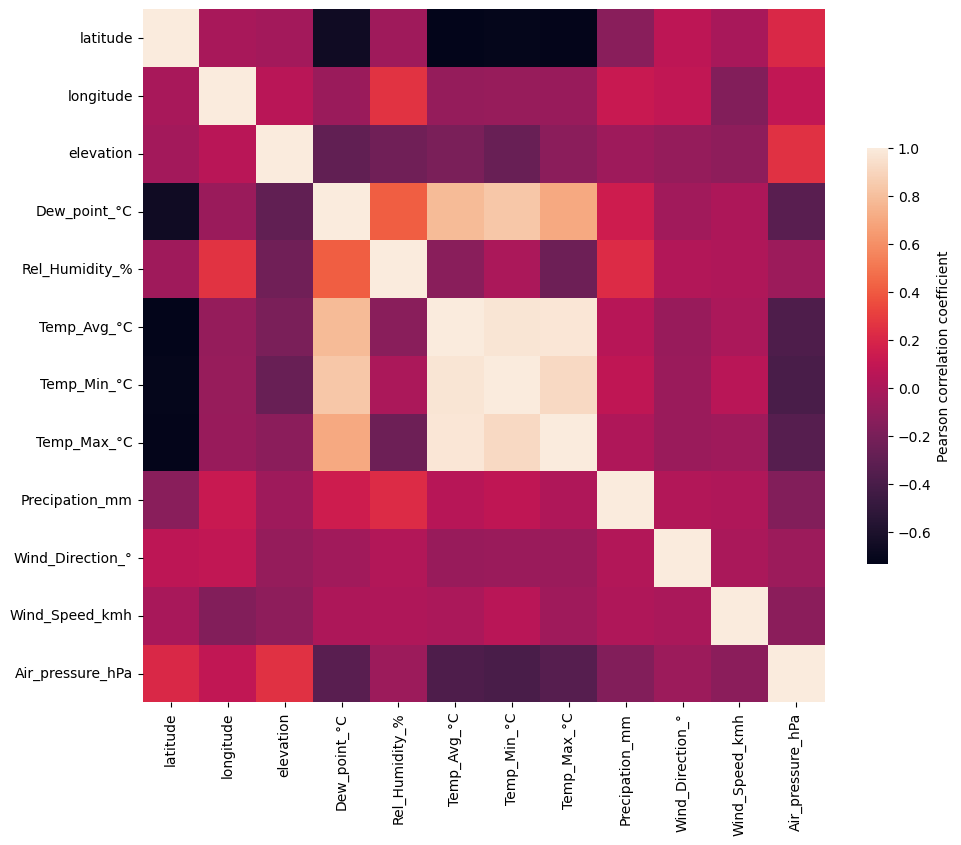

In [7]:
weather_corr = weather_df.select_dtypes(include='number').corr() ## Calculate (Pearson) correlation for all numerical features in dataframe

f, ax = plt.subplots(figsize=(11, 9))
#!# sns.??(weather_corr, ## seaborn.object no function for heatmaps yet
sns.heatmap(weather_corr, ## seaborn.object no function for heatmaps yet
			cbar_kws={"label": "Pearson correlation coefficient", "shrink": 0.6} ## Label adjustments
			) 

## Problem with standard correlation heatmap: colormap not suitable and features not ordered by similarity

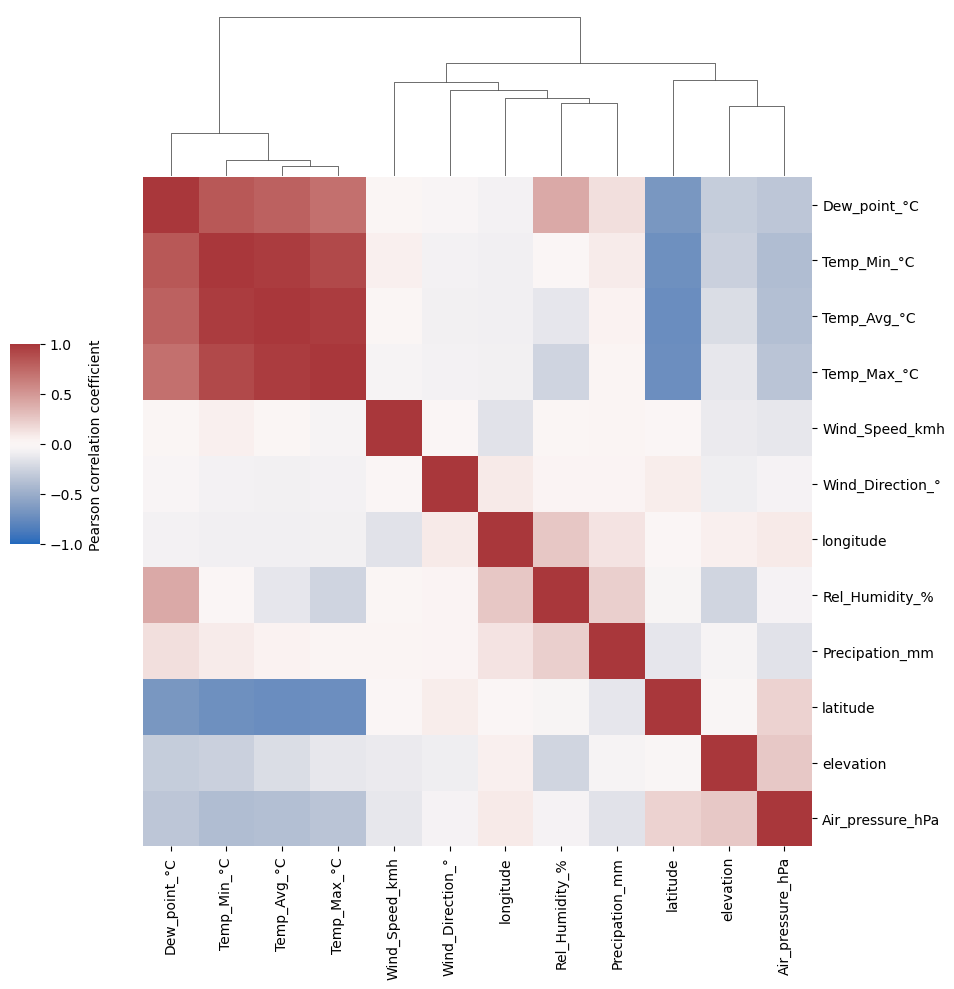

In [8]:
sns.clustermap(weather_corr,                                            ## Clustermap will cluster the features by similarity
			    cmap='vlag',center=0, vmin=-1, vmax=1,                  ## Colormap: correlations range from -1 to +1 and have fixed midpoint at 0                                  
				cbar_kws={"label": "Pearson correlation coefficient"},  ## Color legend description
                cbar_pos = (0.05, 0.45, 0.03, 0.2)						## Change the weird default position of legend
				).ax_row_dendrogram.set_visible(False)					## Dendrogram of feature similarity is identical (symmetric matrix); we can omit it on one side

## What can be seen in the correlation heatmap?
(1) features with (almost) identical information (redundancy) <br>
(2) association of learned embeddings (t-SNE, PCA) with features

## ML show case: predict the manuel text annotation of the weather by the numerical features

In [9]:
weather_df['Condition'].value_counts()

Condition
Cloudy               827
Fair                 734
Clear                557
Overcast             239
Light Rain           108
Fog                  105
Rain                  69
Heavy Rain Shower     60
Heavy Rain            50
Rain Shower           29
Thunderstorm          19
Light Snowfall        11
Snow Shower            4
Sleet                  3
Snowfall               3
Heavy Snowfall         3
Heavy Snow Shower      3
Heavy Sleet            1
Name: count, dtype: int64

## For simplicity reducing to Top categories

In [10]:
weather_df_red = weather_df[
	weather_df['Condition'].isin( 
		weather_df['Condition'].value_counts()[0:6].index  ## Top categories
		) 
	]

weather_df_red

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,...,Rel_Humidity_%,Condition,Temp_Avg_°C,Temp_Min_°C,Temp_Max_°C,Precipation_mm,Wind_Direction_°,Wind_Speed_kmh,Air_pressure_hPa,Continent
1,Peshawar,PK,N,41530,OPPS,34.0167,71.5833,359.0,Asia/Karachi,1944-01-01,...,100.0,Clear,10.8,9.0,12.5,65.0,12.0,11.7,1005.5,Asia
2,Peshawar,PK,N,41530,OPPS,34.0167,71.5833,359.0,Asia/Karachi,1944-01-01,...,94.0,Cloudy,8.9,5.5,13.0,16.0,330.0,20.4,1012.6,Asia
3,Peshawar,PK,N,41530,OPPS,34.0167,71.5833,359.0,Asia/Karachi,1944-01-01,...,54.0,Fair,11.3,4.5,18.0,0.0,270.0,14.2,1020.1,Asia
4,Peshawar,PK,N,41530,OPPS,34.0167,71.5833,359.0,Asia/Karachi,1944-01-01,...,50.0,Fog,13.7,5.5,21.5,0.0,222.0,13.7,1019.3,Asia
5,Peshawar,PK,N,41530,OPPS,34.0167,71.5833,359.0,Asia/Karachi,1944-01-01,...,51.0,Fog,14.9,6.0,21.5,0.0,222.0,8.1,1015.7,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3687,Fuerteventura / Aeropuerto,ES,CN,60035,GCFV,28.4500,-13.8667,22.0,Europe/Madrid,1950-03-27,...,78.0,Clear,19.9,16.7,22.0,0.0,32.0,12.2,1018.1,Europe
3688,Fuerteventura / Aeropuerto,ES,CN,60035,GCFV,28.4500,-13.8667,22.0,Europe/Madrid,1950-03-27,...,57.0,Fair,23.0,18.8,28.0,0.0,0.0,12.5,1016.2,Europe
3689,Fuerteventura / Aeropuerto,ES,CN,60035,GCFV,28.4500,-13.8667,22.0,Europe/Madrid,1950-03-27,...,73.0,Clear,21.9,20.0,26.0,0.0,331.0,27.7,1016.2,Europe
3690,Fuerteventura / Aeropuerto,ES,CN,60035,GCFV,28.4500,-13.8667,22.0,Europe/Madrid,1950-03-27,...,69.0,Fair,20.2,18.0,23.0,0.0,19.0,24.9,1017.0,Europe


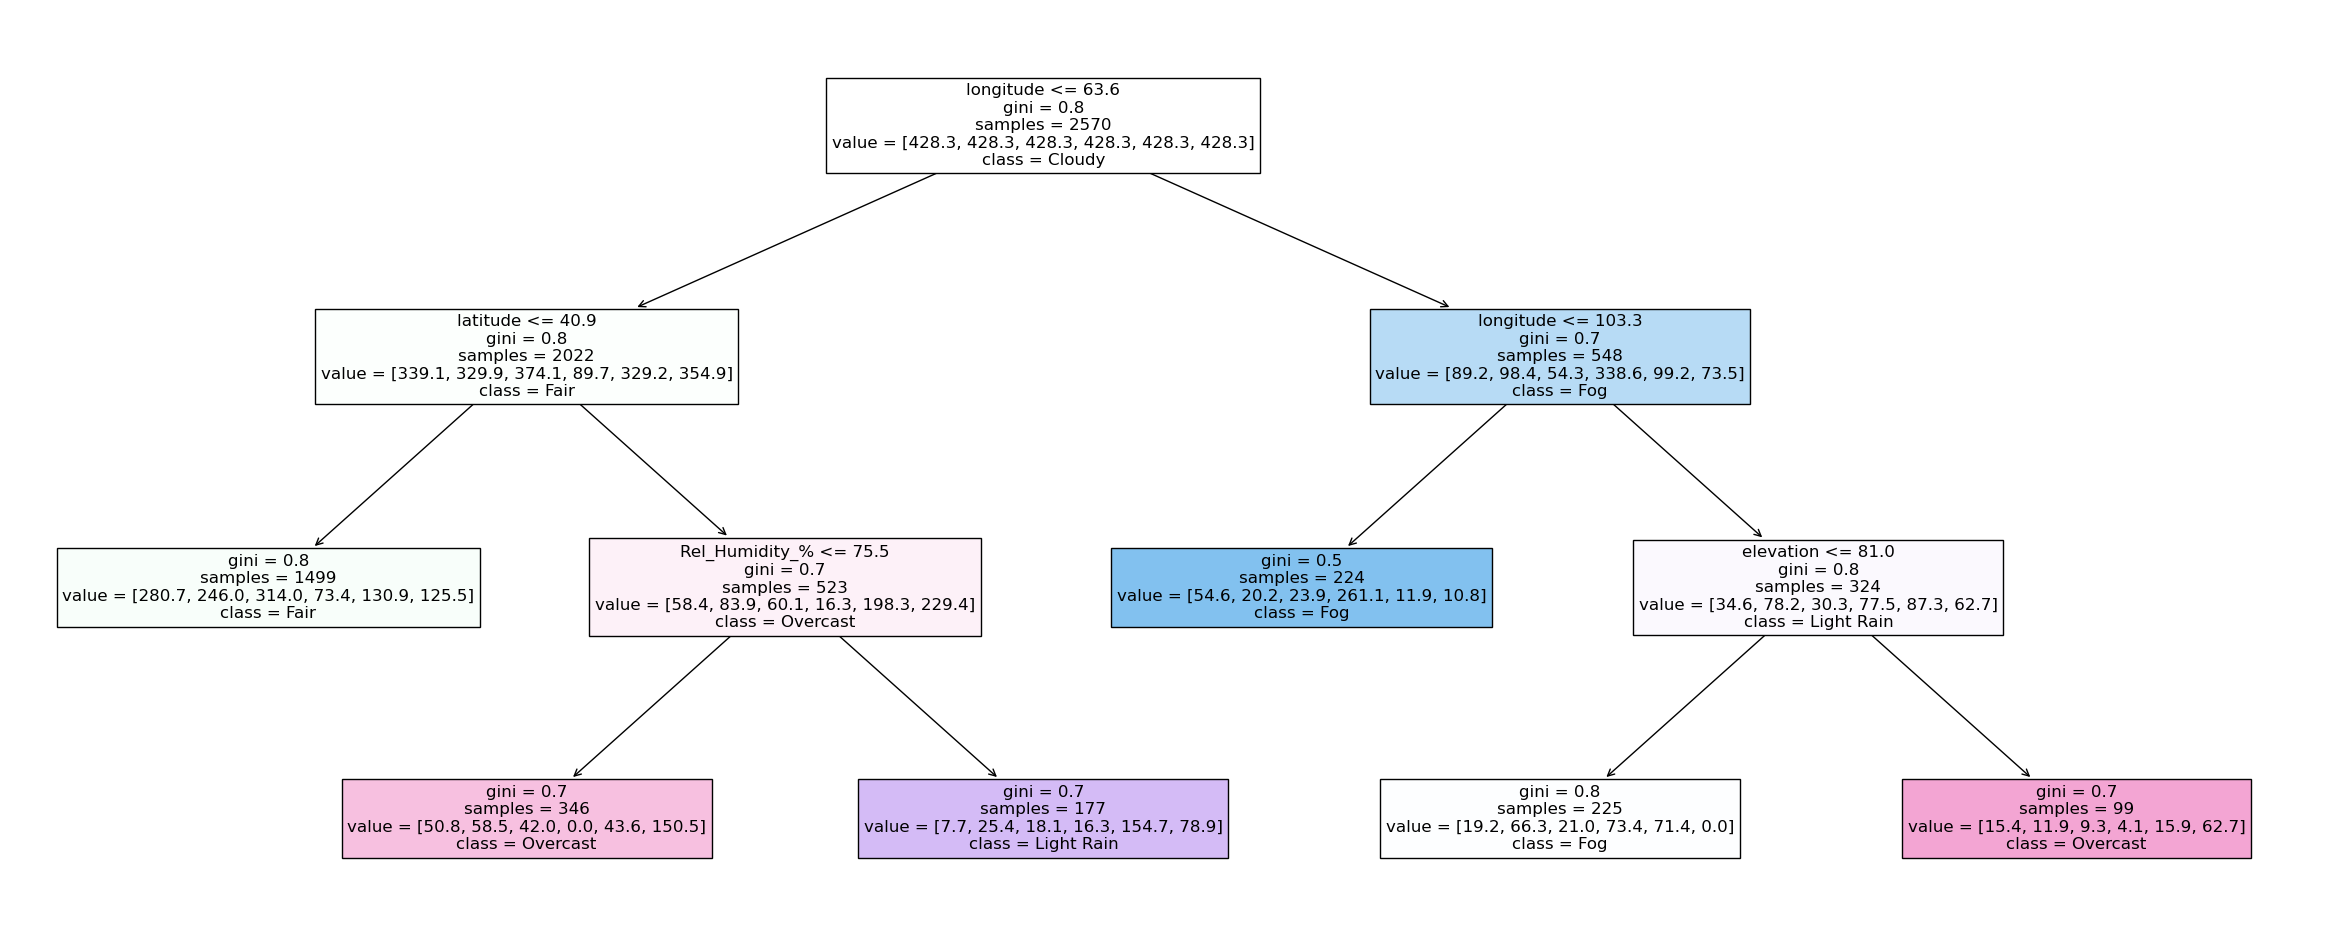

In [14]:
X = weather_df_red.select_dtypes(include='number') 	## Define features
#!# y = weather_df_red[??]  				## Define target variable
y = weather_df_red['Condition']  				## Define target variable

clf = tree.DecisionTreeClassifier(max_depth=5,class_weight="balanced", max_leaf_nodes = 6) ## Define a simple decision tree

clf = clf.fit(X, y)		## training

plt.figure(figsize=(30,12))  ## Plot the full decision tree
anno = tree.plot_tree(	clf, 									## Decision tree
			   	feature_names=clf.feature_names_in_.tolist(),	## Features names
			   	class_names = clf.classes_.tolist(),			## Weather condition text
				filled = True,									## Colored by class decision
				impurity =True,								## For simiplicity exclude impurity values at splits
				precision=1,									## decimal precision
				fontsize=12)									## Fontsize for readibility

## Insights into more complex ML models: Random Forest
### Plotting results: confusion matrix
Important for Confusion Matrix visualization is color + number per entry for pattern exploration and precision

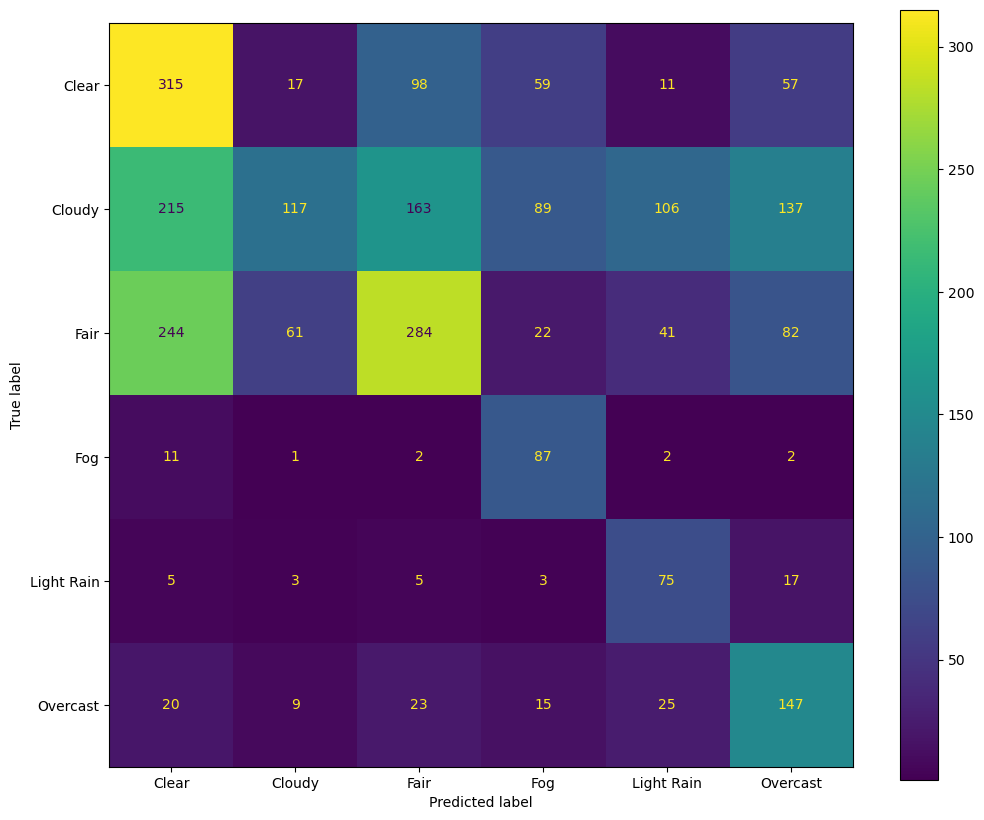

In [15]:
clf_rf = RandomForestClassifier(n_estimators=100,  class_weight="balanced", max_leaf_nodes=20) ## What happens if we negelect class imbalance?
#!# clf_rf = RandomForestClassifier(n_estimators=100,  class_weight=None, max_leaf_nodes=20) ## What happens if we negelect class imbalance?


output = cross_validate(clf_rf, X, y, cv=5, scoring = 'accuracy', return_estimator =True) ## RandomForest is non-deterministic ML -> Cross-validation for more robust results

clf_rf_1 = output['estimator'][0] ## Select a learned RF from the cross-validation

y_pred = clf_rf_1.predict(X)
labels = clf_rf_1.classes_.tolist()
cm = confusion_matrix(y, y_pred, labels=labels)
fig, ax = plt.subplots(figsize=(12,10))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(ax=ax) 

## Getting explainability from feature importance
### Extracting importance from learned models across all cross validations for robustness

In [16]:
feature_importances = pd.DataFrame(X.columns.to_list(), index = X.columns.to_list(), columns=['feature']) ## Empty Data frame definition

for idx,estimator in enumerate(output['estimator']):  ## For each tree in RF
    feature_importances = feature_importances.join(         
            pd.DataFrame(estimator.feature_importances_ ,             ## Calculated feature importance
                        index = estimator.feature_names_in_.tolist(), ## Feature Names
                        columns=['importance_cv'+str(idx+1)])         ## Save from which CV split
            )

# feature_importances
#!# feature_importances_long = pd.??( feature_importances, stubnames="importance_cv",i="feature",j="cv") 
feature_importances_long = pd.wide_to_long( feature_importances, stubnames="importance_cv",i="feature",j="cv") 

feature_importances_long.head() ## We need typically long format for plotting in grammar of graphics


,,importance_cv
feature,cv,
latitude,1,0.124856
longitude,1,0.203709
elevation,1,0.066899
Dew_point_°C,1,0.051925
Rel_Humidity_%,1,0.136801


## Show importance as bar chart including errorbars
### Trick: flip x and y axis for readibility

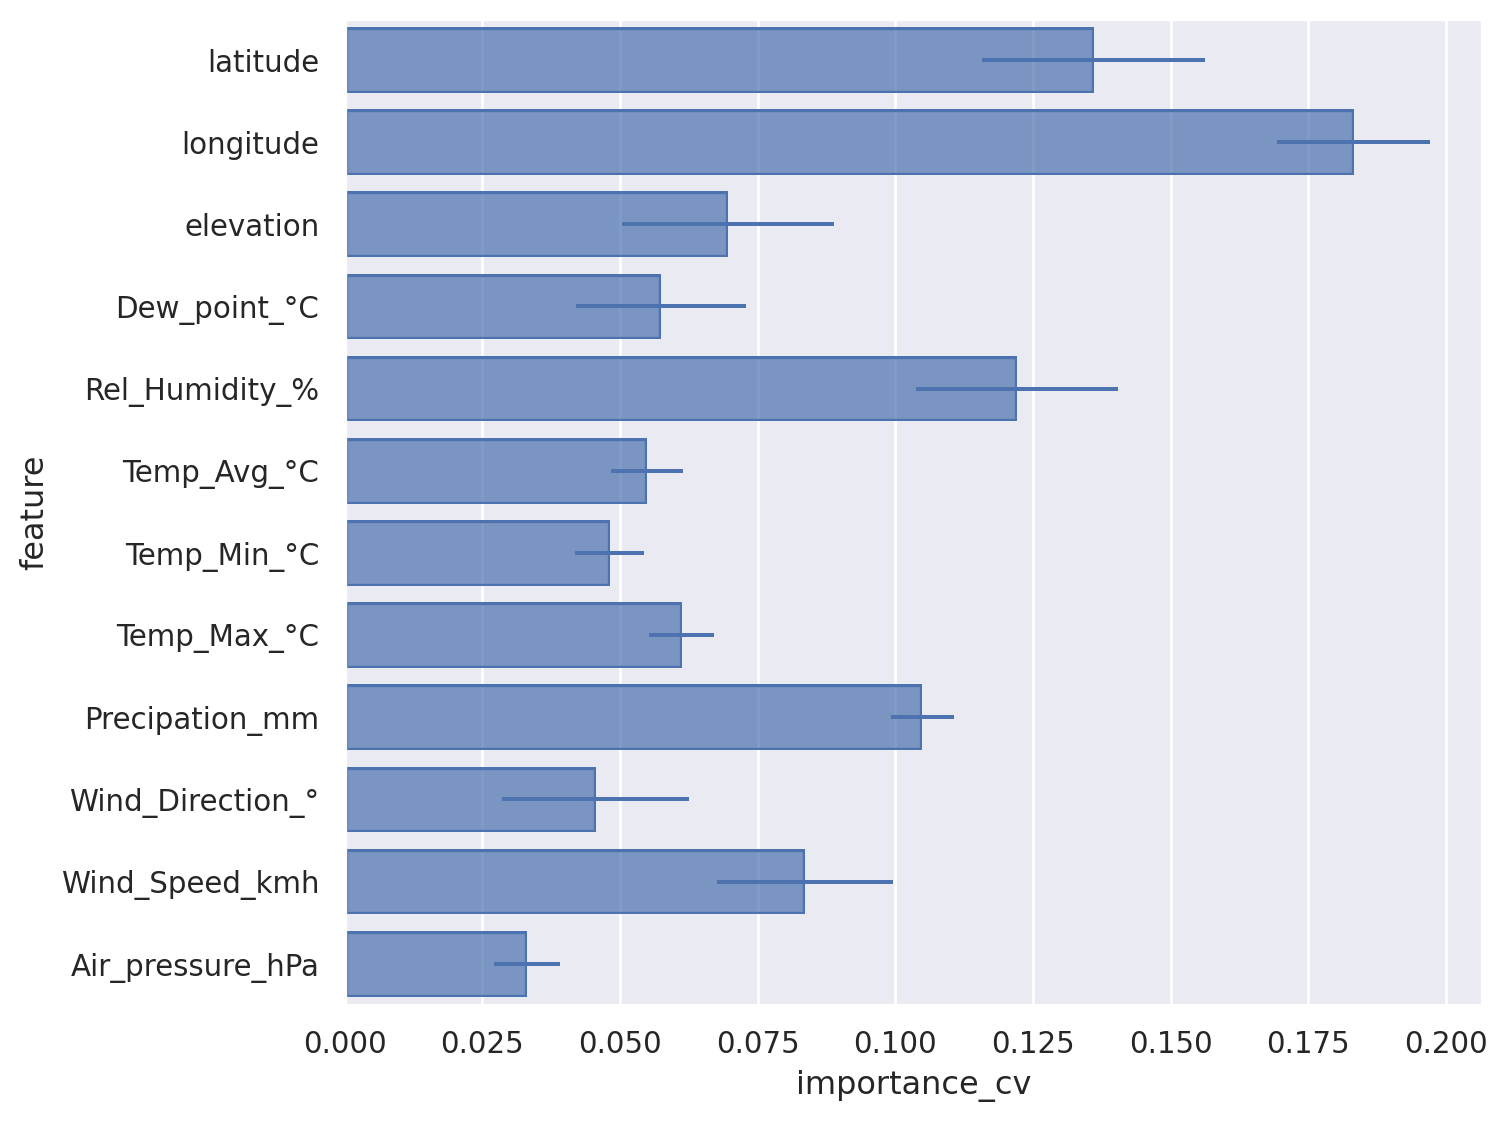

In [14]:
(
#!#    so.Plot(feature_importances_long,x=??,y=??)
    so.Plot(feature_importances_long,x='importance_cv',y='feature')
    .add(so.Bar(), so.Agg())				## Bar plot showing the average
	.add(so.Range(), so.Est(errorbar="sd"))	## Whiskers showing the standard deviation
	.layout(size=(8, 6))	
)

## There are problems with bar charts and errorbars: https://doi.org/10.1371/journal.pbio.1002128
### Better show points/dots for every trained model (sample) and statistics

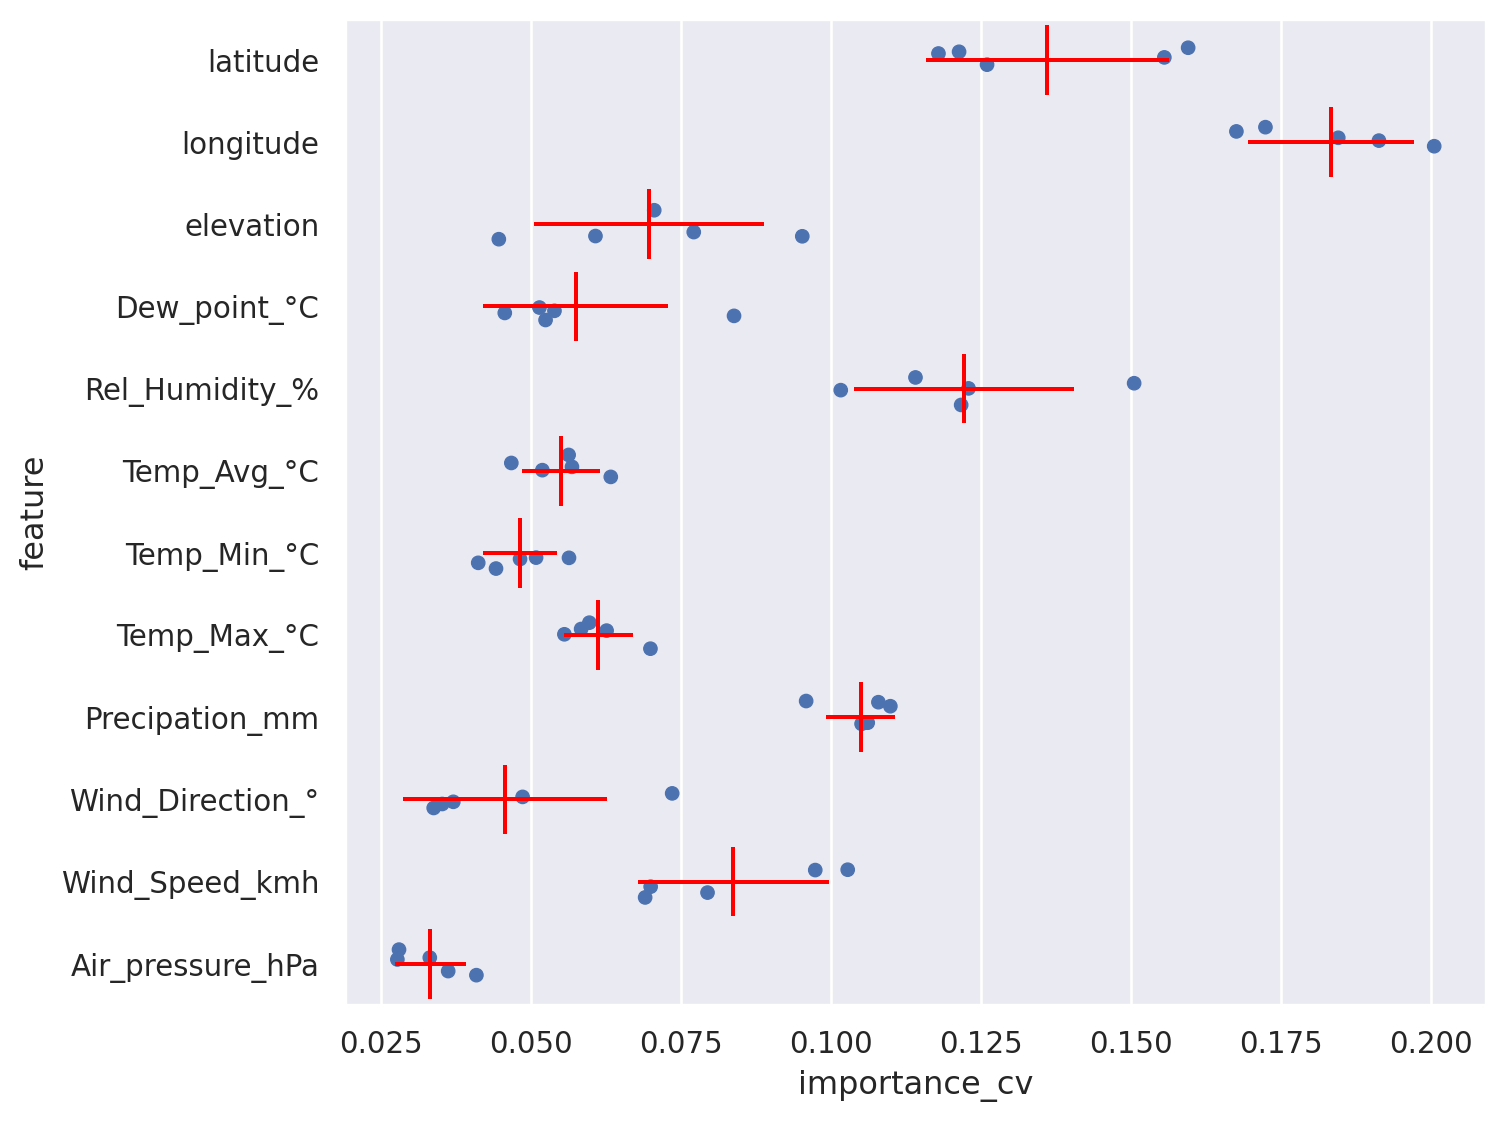

In [15]:
(
    so.Plot(feature_importances_long,x='importance_cv',y='feature')
	.add(so.Dot(pointsize=5), so.Shift(y=.0), so.Jitter(.5)) ## Jitter and Shift avoid overplotting
#!# .add(so.??(color="red"), so.Agg())					## Show a dash with the average
#!# .add(so.??(color="red"), so.Est(errorbar="sd"))		## Show the range of the standard deviation 
    .add(so.Dash(color="red"), so.Agg())					## Show a dash with the average
	.add(so.Range(color="red"), so.Est(errorbar="sd"))		## Show the range of the standard deviation
	.layout(size=(8, 6))	
)